In this project, we aim to develop a classification model for predicting personal loan acceptance using the Thera-Bank dataset. Most Thera-Bank customers are depositors, with a relatively small segment being borrowers (asset customers). The bank seeks to grow this borrower base to boost its loan business and increase interest revenue. Specifically, management is focused on converting liability customers into retail loan customers without losing them as depositors. A previous campaign targeting depositors achieved a conversion rate of 9.6%, prompting the retail marketing team to explore more efficient, targeted strategies. To support this, they plan to build a classifier to identify customers most likely to take a loan, improving conversion rates while minimizing campaign costs.

The dataset contains both customer information and customer response to the last personal loan campaign:

* __ID__: ID of the customer

* __Age__: Age of the customer in completed years

* __Experience__: Amount of work experience in years

* __Income__: Amount of annual income (in thousands)

* __Zipcode__: Postal code in which the client lives

* __Family__: Number of family members

* __CCAvg__: Average monthly spending with the credit card (in thousands)

* __Education__: Education level (1: bachelor's degree, 2: master's degree, 3: advanced/professional degree)

* __Mortgage__: Value of home mortgage, if any (in thousands)

* __Securities Account__: Does the customer have a securities account with the bank?

* __CD Account__: Does the customer have a certificate of deposit account (CD) with the bank?

* __Online__: Does the customer use the internet banking facilities?

* __CreditCard__: Does the customer use a credit card issued by the bank?

* __Personal Loan__: Did this customer accept the personal loan offered in the last campaign? (Target Variable)

__Objective:__ To use different classification models to predict the likelihood that a customer will buy a personal loan.

__Let's get started:__

<a id="import"></a>
# <p style="background-color:midnightblue; font-family:calibri; font-size:130%; color:white; text-align:center; border-radius:10px 10px; padding:15px">Step 1: Import Libraries</p>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.preprocessing import KBinsDiscretizer, OneHotEncoder, StandardScaler
from sklearn.naive_bayes import ComplementNB, BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score
from sklearn.metrics import classification_report, RocCurveDisplay, ConfusionMatrixDisplay
from scipy import stats
from sklearn.base import clone
%matplotlib inline

In [2]:
# upload dataset
from google.colab import files
uploaded = files.upload()

Saving Bank_Personal_Loan_Modelling.xlsx to Bank_Personal_Loan_Modelling.xlsx


<a id="import"></a>
# <p style="background-color:midnightblue; font-family:calibri; font-size:130%; color:white; text-align:center; border-radius:10px 10px; padding:15px">Step 2: Read Dataset</p>

In [3]:
df = pd.read_excel(r'Bank_Personal_Loan_Modelling.xlsx',sheet_name='Data')
df.head(5)

,ID,Age,Experience,Income,ZIP Code,Family,CCAvg,Education,Mortgage,Personal Loan,Securities Account,CD Account,Online,CreditCard
0,1,25,1,49,91107,4,1.6,1,0,0,1,0,0,0
1,2,45,19,34,90089,3,1.5,1,0,0,1,0,0,0
2,3,39,15,11,94720,1,1.0,1,0,0,0,0,0,0
3,4,35,9,100,94112,1,2.7,2,0,0,0,0,0,0
4,5,35,8,45,91330,4,1.0,2,0,0,0,0,0,1


<a id="import"></a>
# <p style="background-color:midnightblue; font-family:calibri; font-size:130%; color:white; text-align:center; border-radius:10px 10px; padding:15px">Step 3: Dataset Univariate Analysis</p>

In [4]:
def check_detail(dataframe):
    d = {'SHAPE': dataframe.shape,
        'COLUMNS': dataframe.columns,
        'INDEX': dataframe.index,
        'VALUE TYPES': dataframe.dtypes,
        'DUPLICATED VALUES': dataframe.duplicated().sum(),
        'NUMBER OF UNIQUE VALUES': dataframe.nunique(),
        'ANY MISSING VALUES': dataframe.isnull().values.any(),
        'MISSING VALUES': dataframe.isnull().sum(),
        'DESCRIBE.T': dataframe.describe([0, 0.05, 0.50, 0.95, 0.99, 1]).T}
    hashtags = '---------------------------'
    for key, val in d.items():
        print(f'{hashtags} {key} {hashtags}')
        print(val)
    print(f'{hashtags} {"LIST END"} {hashtags}')


check_detail(dataframe=df)

--------------------------- SHAPE ---------------------------
(5000, 14)
--------------------------- COLUMNS ---------------------------
Index(['ID', 'Age', 'Experience', 'Income', 'ZIP Code', 'Family', 'CCAvg',
       'Education', 'Mortgage', 'Personal Loan', 'Securities Account',
       'CD Account', 'Online', 'CreditCard'],
      dtype='object')
--------------------------- INDEX ---------------------------
RangeIndex(start=0, stop=5000, step=1)
--------------------------- VALUE TYPES ---------------------------
ID                      int64
Age                     int64
Experience              int64
Income                  int64
ZIP Code                int64
Family                  int64
CCAvg                 float64
Education               int64
Mortgage                int64
Personal Loan           int64
Securities Account      int64
CD Account              int64
Online                  int64
CreditCard              int64
dtype: object
--------------------------- DUPLICATED VALUES 

In [5]:
df.drop('ID', axis=1, inplace=True)

<a id="import"></a>
# <p style="background-color:midnightblue; font-family:calibri; font-size:130%; color:white; text-align:center; border-radius:10px 10px; padding:15px">Step 4: Correlation Analysis</p>

Let's compare __Spearman__'s correlation with __Pearson__'s correlation:

*  Pearson works with a linear relationship between the two variables whereas the Spearman works with monotonic relationships as well.
* Pearson works with raw data values of the variables whereas Spearman works with rank-ordered variables.


When the variables have a "might be monotonic, might be linear" relationship, our best bet is to use __Spearman__ rather than Pearson:

In [6]:
# Define a colormap
royalblue = LinearSegmentedColormap.from_list('royalblue', [(0, (1,1,1)), (1, (0.25,0.41,0.88))])
royalblue_r = royalblue.reversed()

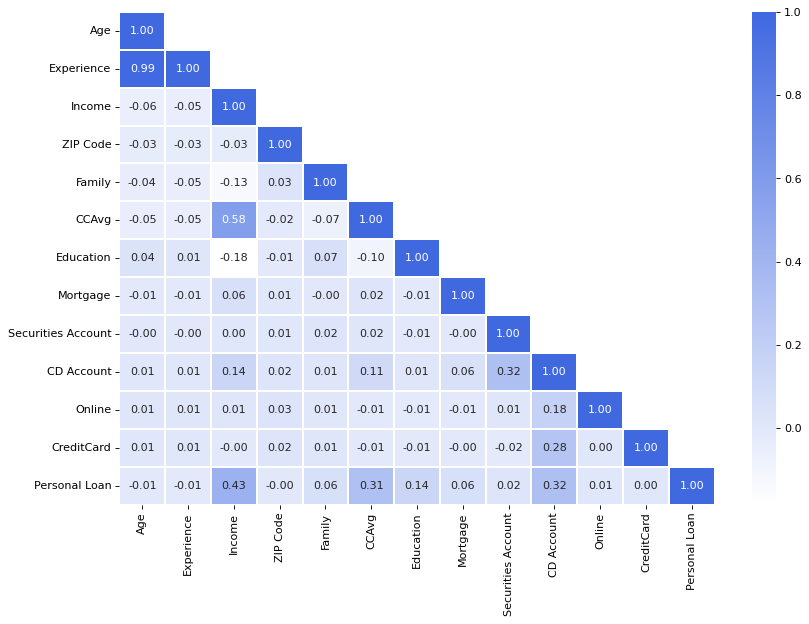

In [7]:
# Calculation of the Spearman correlation
target = 'Personal Loan'
df_ordered = pd.concat([df.drop(target,axis=1), df[target]],axis=1)
corr = df_ordered.corr(method='spearman')

# Create a mask so that we see the correlation values only once
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask,1)] = True

# Plot the heatmap correlation
plt.figure(figsize=(12,8), dpi=80)
sns.heatmap(corr, mask=mask, annot=True, cmap=royalblue, fmt='.2f', linewidths=0.2)
plt.show()

<h4 align="left"><font color='lightblue'>Conclusion:</font></h4>

* __Personal Loan__ is highly correlated with __Income, CD_Account, CCAvg__.
* __Experience__ is highly correlated with __Age__. (ρ = 0.99)
* __CCAvg__ is correlated with __Income__ to a good extent. (ρ = 0.58)

<a id="import"></a>
# <p style="background-color:midnightblue; font-family:calibri; font-size:130%; color:white; text-align:center; border-radius:10px 10px; padding:15px">Step 5: Data Cleansing</p>

__Data cleansing__, also known as data cleaning, is the process of preparing and structuring raw data to be used for further analysis. It includes identifying and correcting incorrect or incomplete data, removing irrelevant data, filling in missing values, and transforming existing variables. Data cleaning is an essential step in any machine learning project because it helps improve the accuracy of a model by reducing noise and errors. Poorly cleaned data can lead to overly complex models which are difficult to interpret and have a high chance of overfitting. Furthermore, dirty data can significantly reduce the accuracy of a model; even a small amount of noise will decrease its performance drastically.

<a id="import"></a>
# <p style="background-color:midnightblue; font-family:calibri; font-size:90%; color:white; text-align:center; border-radius:10px 10px; padding:10px">Step 5.1: Noise Treatment</p>

__Noise treatment__ is the process by which irrelevant or noisy sections of a dataset are removed before the data can be used for analysis.

<h3 align="left"><font color='lightblue'>I) ZIP Code Noise Treatment:</font></h3>

In the 3d step, we found that the __ZIP Code__ feature has a minimum value that is much smaller than the average value. Let us look at the histogram of this feature again:

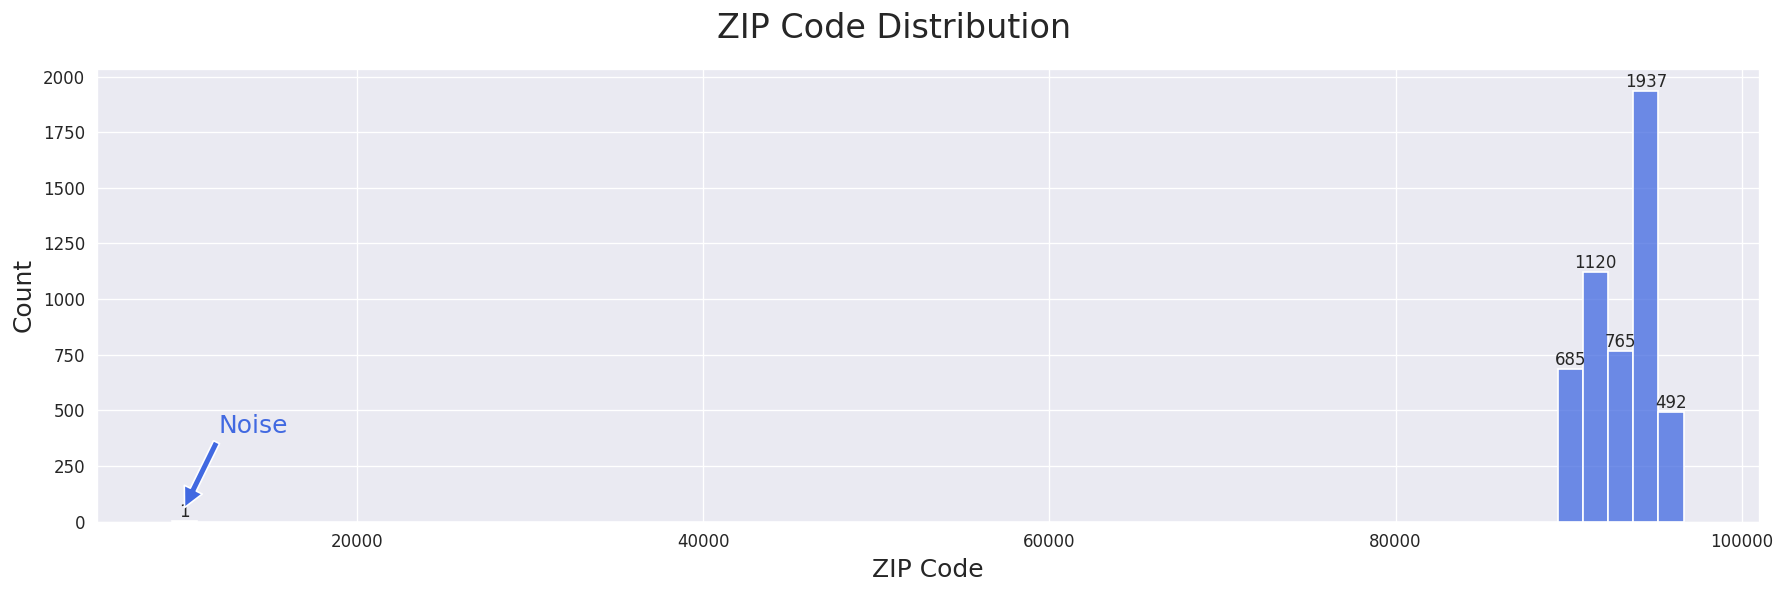

In [8]:
# Set the style of the graph
sns.set_style('darkgrid')
color = 'royalblue'

# Plot histogram
plt.figure(figsize=(15,5), dpi=120)
graph = sns.histplot(x='ZIP Code', data=df, bins=60, color=color)

# Show non-zero values of the individual bars
labels = [str(v) if v else '' for v in graph.containers[0].datavalues]
graph.bar_label(graph.containers[0], labels=labels)

plt.annotate('Noise', xy=(10000,60), xytext=(12000,400), color=color, fontsize=15,
             arrowprops=dict(facecolor=color, shrink=0.01))
plt.xlabel('ZIP Code', fontsize=15)
plt.ylabel('Count', fontsize=15)
plt.suptitle('ZIP Code Distribution', fontsize=20)
plt.tight_layout()
plt.show()

In [9]:
df[df['ZIP Code']<20000]

,Age,Experience,Income,ZIP Code,Family,CCAvg,Education,Mortgage,Personal Loan,Securities Account,CD Account,Online,CreditCard
384,51,25,21,9307,4,0.6,3,0,0,0,0,1,1


We found 1 noisy data in ZIP Code. We drop the corresponding sample because it contains 4 digits, while the other values of this feature all have 5 digits:

In [10]:
df.drop(df[df['ZIP Code']<20000].index, inplace=True)
df.reset_index(drop=True, inplace =True)

<h3 align="left"><font color='lightblue'>II) Experience Noise Treatment:</font></h3>

As seen in the third step, the dataset contains negative values for Experience. Considering that the values of this feature indicate work experience in years, these negative values are considered noise:

In [11]:
df[df['Experience']<0]['Experience'].count()

np.int64(52)

Count unique negative values:

In [12]:
df[df['Experience']<0]['Experience'].value_counts()

,count
Experience,
-1,33
-2,15
-3,4


Since the number of these noise values in the Experience feature is small, we assume that these values are incorrectly recorded as negative and replace them with their absolute value:

In [13]:
df['Experience'] = df['Experience'].apply(abs)

<a id="import"></a>
# <p style="background-color:midnightblue; font-family:calibri; font-size:90%; color:white; text-align:center; border-radius:10px 10px; padding:10px">Step 5.2: Outlier Treatment</p>

__Outliers__ are data points that are significantly higher or lower than most other values in the set.

__Kurtosis__ is a measure of the "tailedness" or shape of a distribution. If the Kurtosis value is greater than 3, it is likely that the variable contains outliers. This is because excessive kurtosis indicates that the data points have a higher concentration in the tails than normal, which may indicate the presence of outliers.

In 3d step, of all the continuous features, only the __Mortgage__ feature had a kurtosis value above 3. To detect possible outliers in this feature, we use __Z-score technique__.

Let us look at the distribution of Mortgage again:

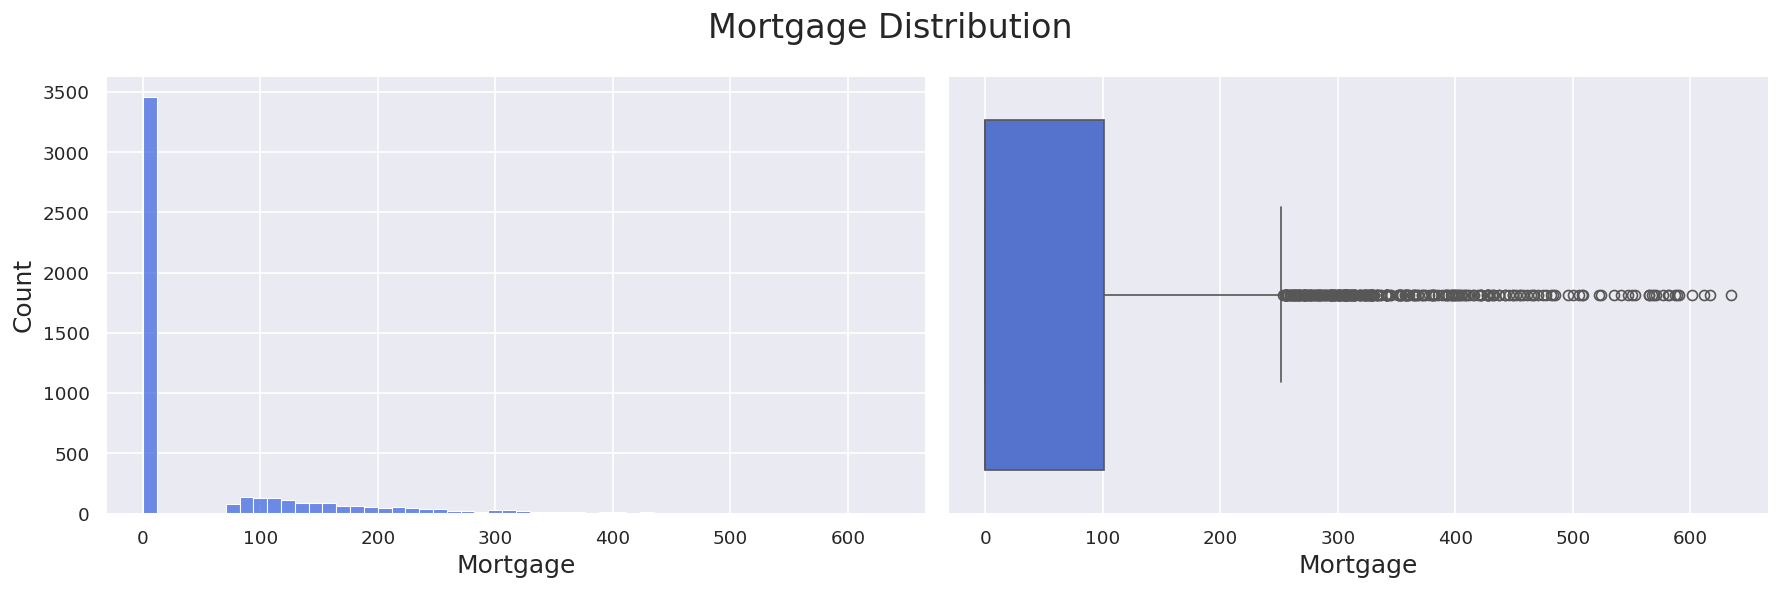

In [14]:
sns.set(rc = {'axes.labelsize' : 15})
fig, ax = plt.subplots(1, 2, figsize=(15,5), dpi=120)
sns.histplot(x='Mortgage', data=df, color='royalblue', ax=ax[0])
sns.boxplot(x='Mortgage', data=df, color='royalblue', ax=ax[1])
plt.suptitle('Mortgage Distribution', fontsize=20)
plt.tight_layout()
plt.show()

The __Z-score__ method for outlier detection is a statistical technique used to detect outliers from data sets by calculating how many standard deviations away from the mean each data point is. A data point with a Z score of more than 3 standard deviation away from the mean is considered an outlier. We use the __scipy.stats__ module to perform the zscore technique:

In [15]:
df[stats.zscore(df['Mortgage'])>3]['Mortgage'].count()

np.int64(105)

We found 105 records with a Z-score mortgage value greater than 3. Therefore, we consider these 105 records as outliers and filter out these records from our dataset:

In [16]:
outlier_indexes = df[stats.zscore(df['Mortgage'])>3].index
df.drop(outlier_indexes, inplace=True)
df.reset_index(drop=True, inplace=True)

<a id="import"></a>
# <p style="background-color:midnightblue; font-family:calibri; font-size:90%; color:white; text-align:center; border-radius:10px 10px; padding:10px">Step 5.3: Missing Value Treatment</p>

In the 3rd step, we found that our dataset does not contain any __missing values__. Now let us check again if there is any missing value:

In [17]:
df.isnull().sum().sum()

np.int64(0)

It is clear that the dataset does not contain any missing values.

<a id="import"></a>
# <p style="background-color:midnightblue; font-family:calibri; font-size:90%; color:white; text-align:center; border-radius:10px 10px; padding:10px">Step 5.4: Duplicate Values Treatment</p>

__Duplicate Values Treatment__ is the process of removing duplicate records from the dataset before feeding them into a machine learning algorithm. This is to ensure that only unique samples are used to train and evaluate the machine learning algorithm:

In [18]:
df[df.duplicated(keep=False)].sum().sum()

np.float64(0.0)

It is clear that the dataset does not contain duplicates.

<a id="import"></a>
# <p style="background-color:midnightblue; font-family:calibri; font-size:90%; color:white; text-align:center; border-radius:10px 10px; padding:10px">Step 5.5: Feature Transformation</p>

In the dataset, CCAVG represents average monthly credit card spending, but Income represents the amount of annual income.
To make the units of the features equal, we convert average monthly credit card spending to annual:

In [19]:
df['CCAvg'] = df['CCAvg']*12

<a id="import"></a>
# <p style="background-color:midnightblue; font-family:calibri; font-size:130%; color:white; text-align:center; border-radius:10px 10px; padding:15px">Step 6: Bivariate Analysis</p>

Having considered each variable individually in univariate analysis in Step 3, we will now examine them again with respect to the __Target Variable__.

First, we will identify the relationship between the __Target Variable__ and the __Categorical Features__. Then we will look at the __Numerical Features__ compared to the __Target Variable__.

<a id="import"></a>
# <p style="background-color:midnightblue; font-family:calibri; font-size:90%; color:white; text-align:center; border-radius:10px 10px; padding:10px">Step 6.1: Categorical Features vs Target</p>

In this part, we will create __100% stacked bar and column charts__ showing the proportion of purchased and non-purchased loans for each category of categorical features seprately:

In [20]:
# Define a list containing the names of important categorical features in the dataset
Cat_Features = ['CD Account','Education','Family','Securities Account','Online','Securities Account']

# Define the target name in a variable for simplicity
Target = 'Personal Loan'

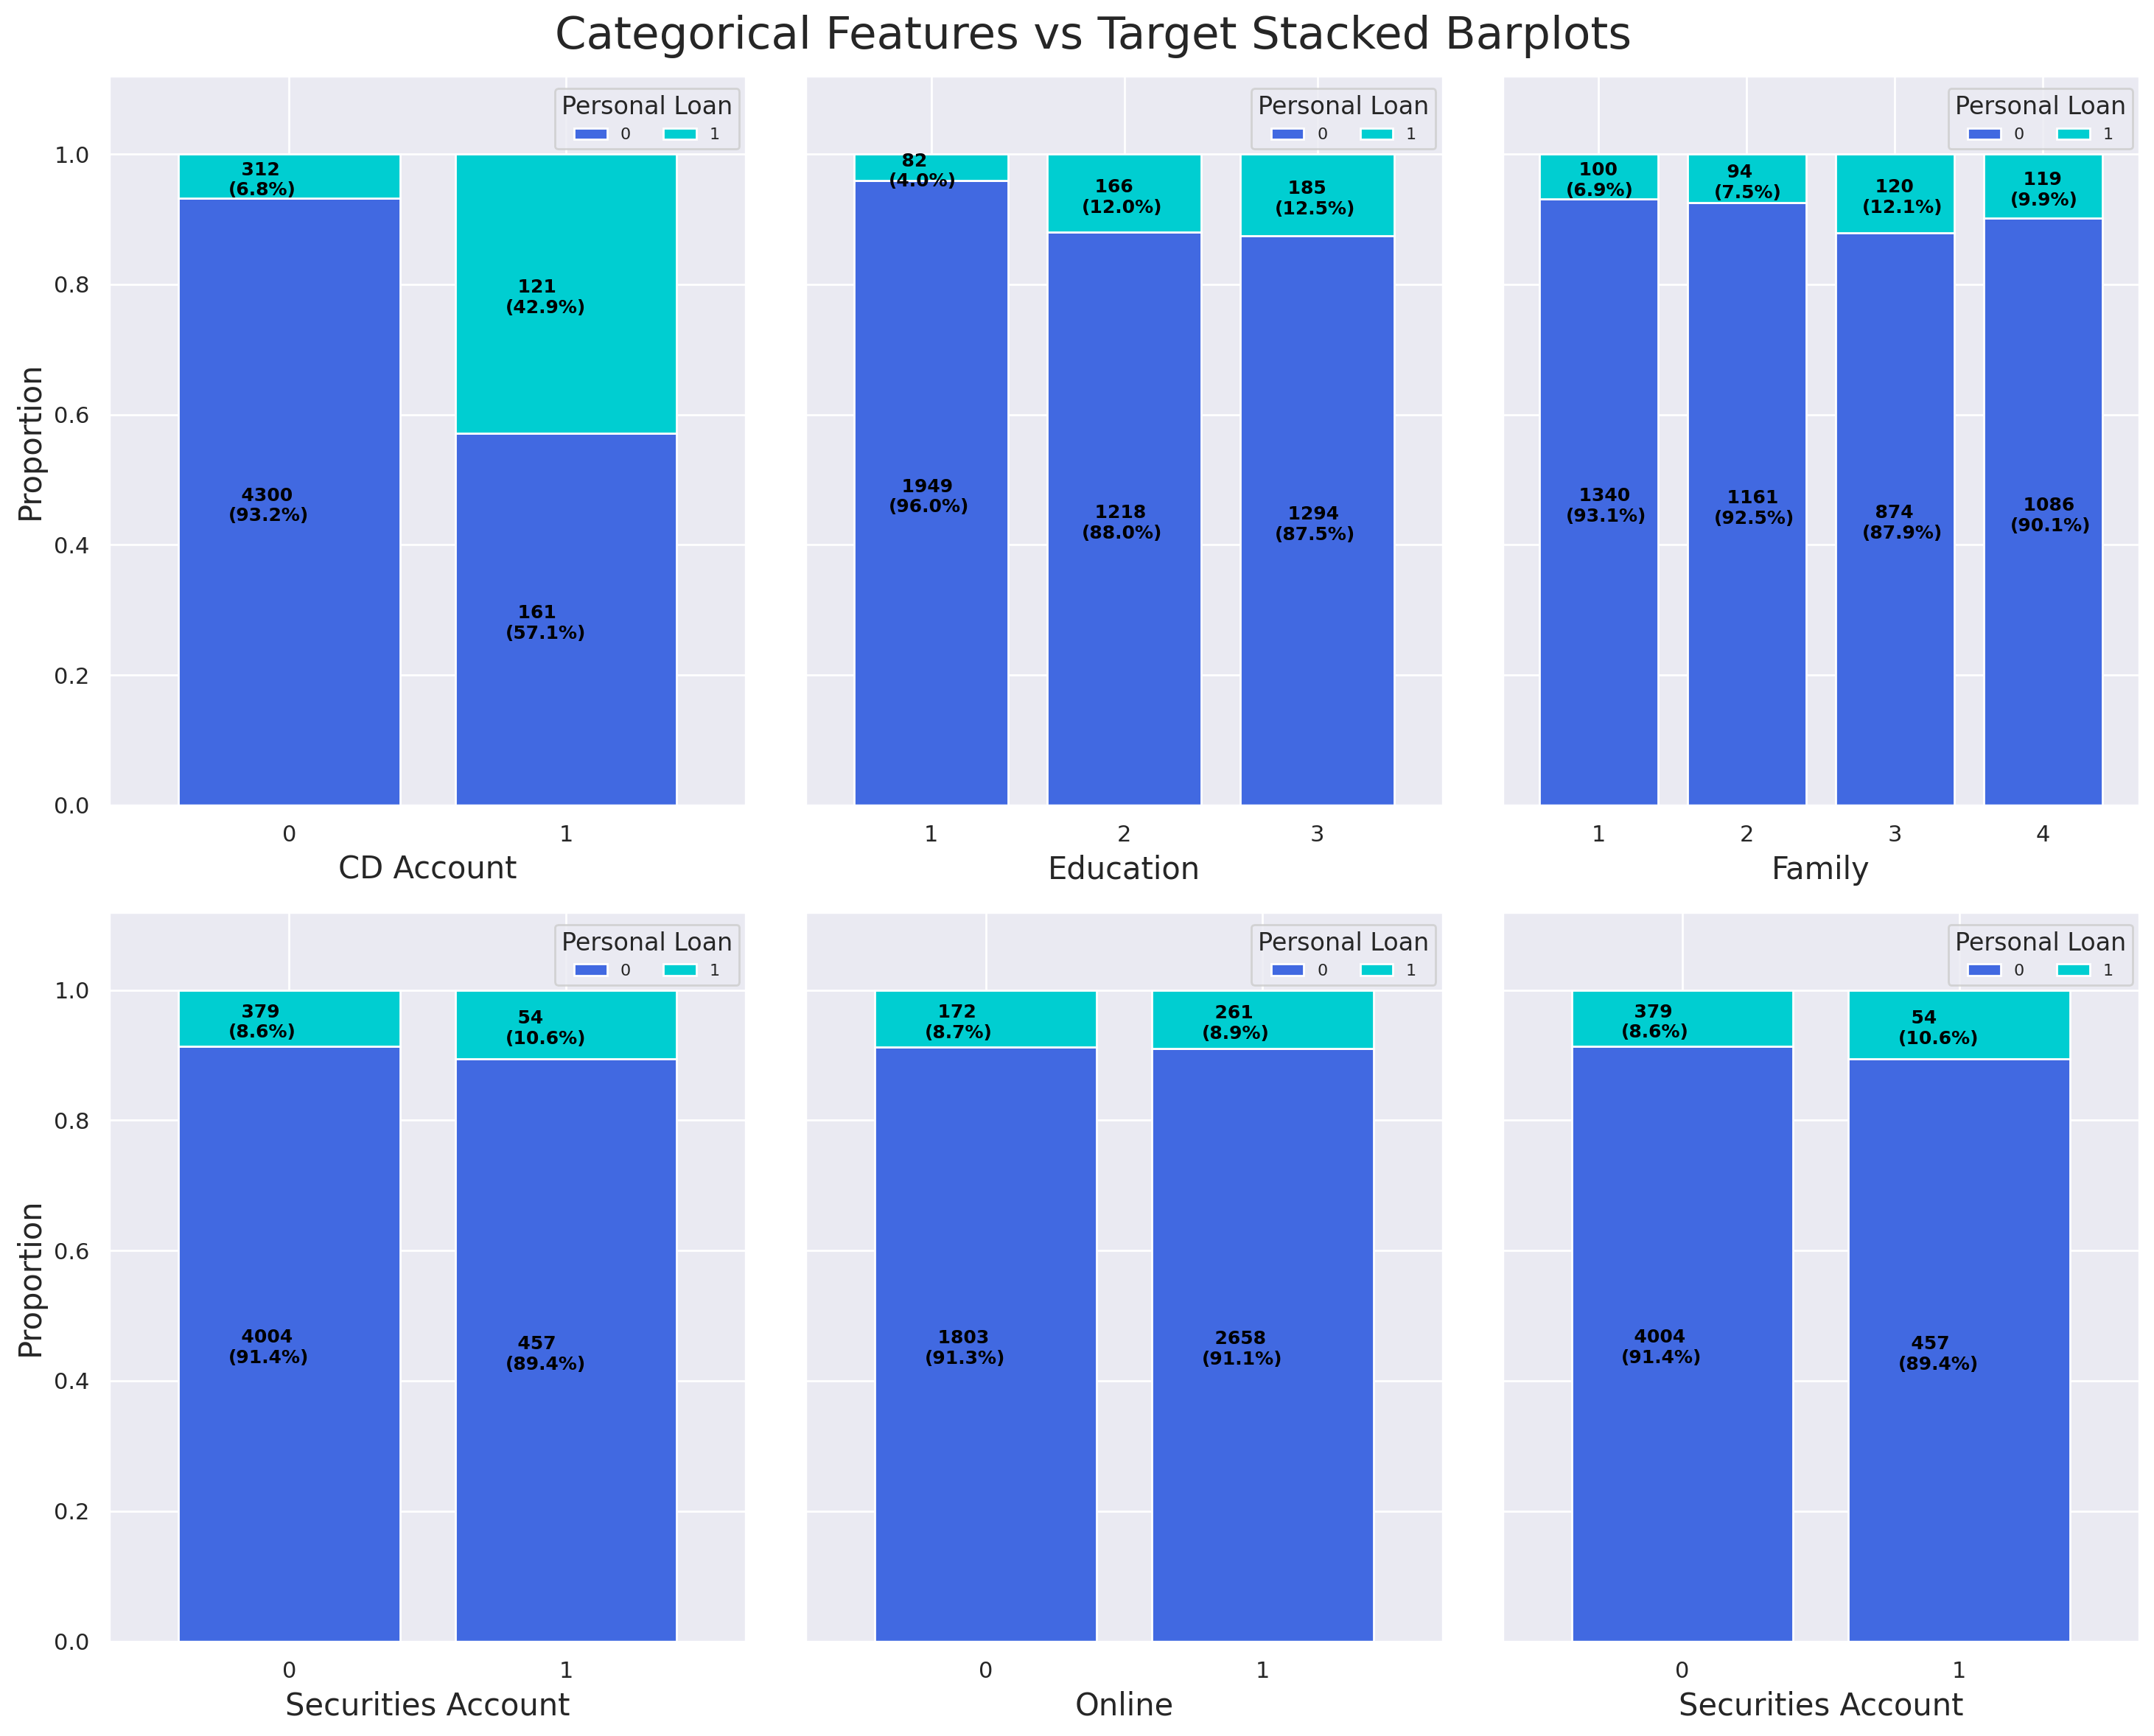

In [21]:
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(15,12), dpi=200)

for i,col in enumerate(Cat_Features):

    # Create a cross tabulation showing the proportion of purchased and non-purchased loans for each category of the feature
    cross_tab = pd.crosstab(index=df[col], columns=df[Target])

    # Using the normalize=True argument gives us the index-wise proportion of the data
    cross_tab_prop = pd.crosstab(index=df[col], columns=df[Target], normalize='index')

    # Define colormap
    cmp = ListedColormap(['royalblue', 'darkturquoise'])

    # Plot stacked bar charts
    x, y = i//3, i%3
    cross_tab_prop.plot(kind='bar', ax=ax[x,y], stacked=True, width=0.8, colormap=cmp,
                        legend=False, ylabel='Proportion', sharey=True)

    # Add the proportions and counts of the individual bars to our plot
    for idx, val in enumerate([*cross_tab.index.values]):
        for (proportion, count, y_location) in zip(cross_tab_prop.loc[val],cross_tab.loc[val],cross_tab_prop.loc[val].cumsum()):
            ax[x,y].text(x=idx-0.22, y=(y_location-proportion)+(proportion/2)-0.03,
                         s = f'  {count}\n({np.round(proportion * 100, 1)}%)',
                         color = "black", fontsize=9, fontweight="bold")

    # Add legend
    ax[x,y].legend(title='Personal Loan', loc=(0.7,0.9), fontsize=8, ncol=2)
    # Set y limit
    ax[x,y].set_ylim([0,1.12])
    # Rotate xticks
    ax[x,y].set_xticklabels(ax[x,y].get_xticklabels(), rotation=0)


plt.suptitle('Categorical Features vs Target Stacked Barplots', fontsize=22)
plt.tight_layout()
plt.show()

<h4 align="left"><font color='lightblue'>Conclusion:</font></h4>

* The customer who has a certificate of deposit (CD) with the bank appears to buy personal loans from the bank.

* Customers with higher levels of education are more likely to buy personal loans.

* The number of family members has no significant effect on the probability of buying personal loans.

* Customers who have or do not have a securities account at the bank have no influence on the probability of buying a personal loan.

* The customer who uses or does not use internet banking does not seem to have any influence on the probability of buying a personal loan.

* The customer who uses or does not use a credit card does not appear to have an impact on the likelihood of purchasing a personal loan.

<a id="import"></a>
# <p style="background-color:midnightblue; font-family:calibri; font-size:90%; color:white; text-align:center; border-radius:10px 10px; padding:10px">Step 6.2: Numerical Features vs Target</p>

In this part, we will try to find the __mean__ and __distribution__ of numerical features for which customers purchase a personal loan versus the mean and distribution of numerical features who do not:

In [22]:
# Define a list containing the names of important numerical features in the dataset
Num_Features = ['CCAvg','Income','Mortgage','Age','Experience']

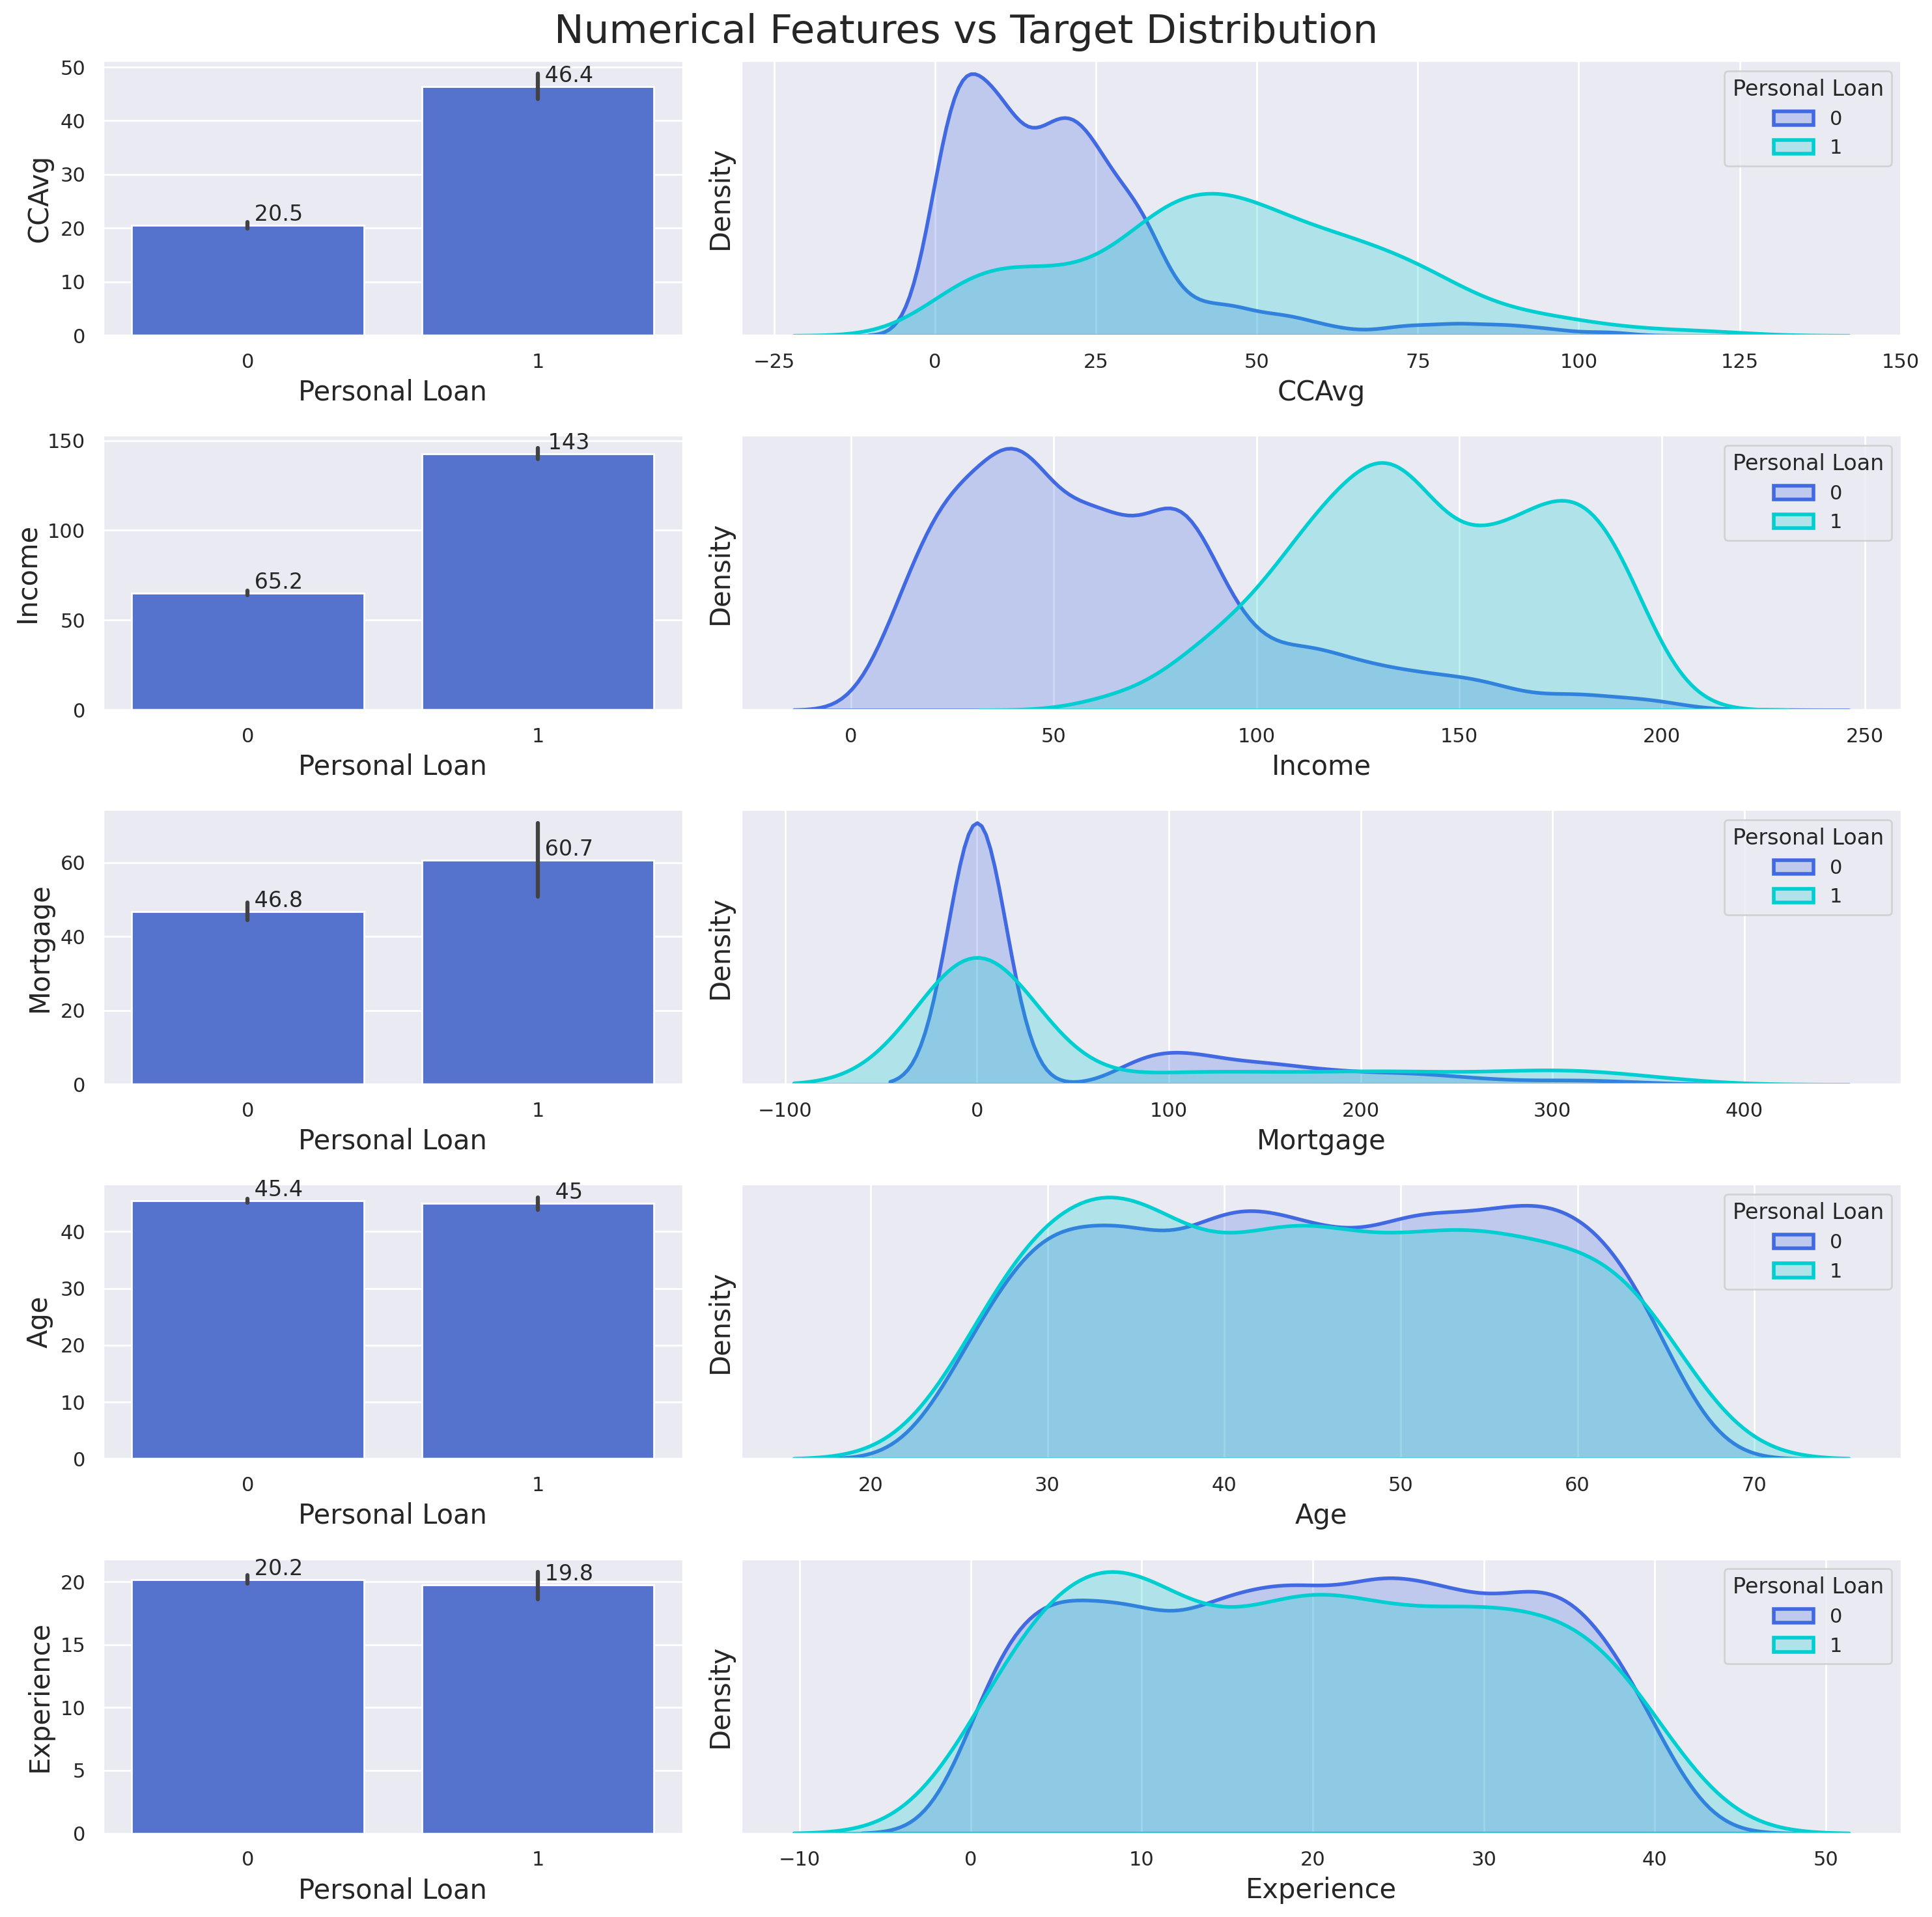

In [23]:
sns.set_palette(['royalblue', 'darkturquoise'])

fig, ax = plt.subplots(5, 2, figsize=(15,15), dpi=200, gridspec_kw={'width_ratios': [1, 2]})

for i,col in enumerate(Num_Features):
    # barplot
    graph = sns.barplot(data=df, x=Target, y=col, ax=ax[i,0])
    # kde Plot
    sns.kdeplot(data=df[df[Target]==0], x=col, fill=True, linewidth=2, ax=ax[i,1], label='0')
    sns.kdeplot(data=df[df[Target]==1], x=col, fill=True, linewidth=2, ax=ax[i,1], label='1')
    ax[i,1].set_yticks([])
    ax[i,1].legend(title='Personal Loan', loc='upper right')
    # Add bar sizes to our plot
    for cont in graph.containers:
        graph.bar_label(cont, fmt='         %.3g')

plt.suptitle('Numerical Features vs Target Distribution', fontsize=22)
plt.tight_layout()
plt.show()

<h4 align="left"><font color='lightblue'>Conclusion:</font></h4>

* Customers who spend more on credit cards are more likely to take out personal loans.

* Customers with high incomes are more likely to purchase a personal loan.

* Customers with a high mortgage value are more likely to purchase personal loans.

* It can be inferred that the age of customers has no influence on the probability of purchasing personal loans.

* The effect of the amount of work experience on the purchase of a loan is similar to that of the age of the customer. The distribution of the Experience is very similar to the distribution of Age, as Experience is strongly correlated with Age.

>Therefore, we remove Experience because it doesn't provide any more information than Age:

In [24]:
df.drop('Experience', axis=1, inplace=True)

In [25]:
df.head()

,Age,Income,ZIP Code,Family,CCAvg,Education,Mortgage,Personal Loan,Securities Account,CD Account,Online,CreditCard
0,25,49,91107,4,19.2,1,0,0,1,0,0,0
1,45,34,90089,3,18.0,1,0,0,1,0,0,0
2,39,11,94720,1,12.0,1,0,0,0,0,0,0
3,35,100,94112,1,32.4,2,0,0,0,0,0,0
4,35,45,91330,4,12.0,2,0,0,0,0,0,1


<a id="import"></a>
# <p style="background-color:midnightblue; font-family:calibri; font-size:130%; color:white; text-align:center; border-radius:10px 10px; padding:15px">Step 7: Train Test Split</p>

First of all, it is necessary to define the __features (X)__ and the output __labels (y)__ of the given dataset. X is a dataframe containing the different feature values for all given observations, while y is a series containing the categorical labels belonging to each observation:

In [26]:
X = df.drop('Personal Loan', axis=1)
y = df['Personal Loan']

We need to perform __train test split__ in supervised machine learning to evaluate the performance of a model after it has been trained. The data set is typically divided into two parts; the training set which is used to train the model, and the test set which is used to measure how well the model performs on new data. Train test split allows us to assess the generalization power of the model by checking its performance on unseen data. This technique can be used to identify any bias and variance in the model and ensure that it generalizes well on unseen examples.

____
<h2 align="left"><font color='lightblue'>Imbalanced dataset:</font></h2>

Imbalanced dataset is a dataset where the classes are not balanced or equal. This means there are an unequal number of samples from each target class and some classes may have significantly more samples than others.

As we saw in the 3d step, the dataset we are working on is an imbalanced dataset. Let's check it again:

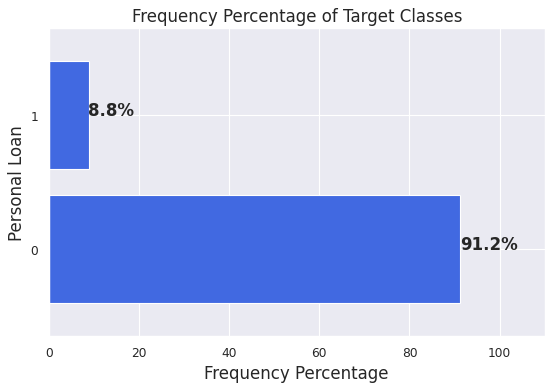

In [27]:
plt.figure(dpi=80)

# Plot frequency percentages barplot
df['Personal Loan'].value_counts(normalize=True).mul(100).plot(kind='barh', width=0.8, figsize=(8,5))

# Add frequency percentages to the plot
labels = df['Personal Loan'].value_counts(normalize=True).mul(100).round(1)
for i in labels.index:
    plt.text(labels[i], i, str(labels[i])+ '%', fontsize=15, weight='bold')

plt.xlim([0, 110])
plt.xlabel('Frequency Percentage', fontsize=15)
plt.ylabel('Personal Loan', fontsize=15)
plt.title('Frequency Percentage of Target Classes', fontsize=15)
plt.show()

As can be seen, __the dataset we are working on is imbalanced.__

____
<h2 align="left"><font color='lightblue'>Problems with Imbalanced Datasets:</font></h2>

1. Imbalanced datasets can lead to algorithms that are biased towards the majority class. This means that any classification algorithm trained on an imbalanced dataset will often inaccurately classify minority classes as the majority class.


2. The performance of a machine learning model can become highly skewed when it is fed with imbalanced data. For example, our dataset has 91.2% class 0 and 8.8% class 1, then the learning model could be easily optimized to just predict all test input as belonging to class 0 and still get 91.2% accuracy!


3. If a model is trained on data which is heavily imbalanced, it can develop an incorrect understanding of the underlying trends in the data. The model may not be able to recognize how certain values are distributed among different classes or even how certain classes overlap with each other.

____
<h2 align="left"><font color='lightblue'>Techniques to Handle Imbalanced Dataset:</font></h2>

<h3 align="left"><font color='royalblue'>1. The approach to train test split:</font></h3>

The approach to train test split when dealing with __imbalanced datasets__ is to use __stratification__. Stratification is an important step in splitting imbalanced datasets into training and test sets. Stratification ensures that the proportion of each class remains the same across both the training and test sets. This is important as it allows for a more accurate evaluation of the model, avoiding bias due to a disproportion of one class being over-represented in either dataset. Stratified sampling also ensures that any trends or correlations among different classes that exist within the overall dataset are preserved after splitting into training and test datasets:

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

Let's see the proportion of each class across both the training and test sets:

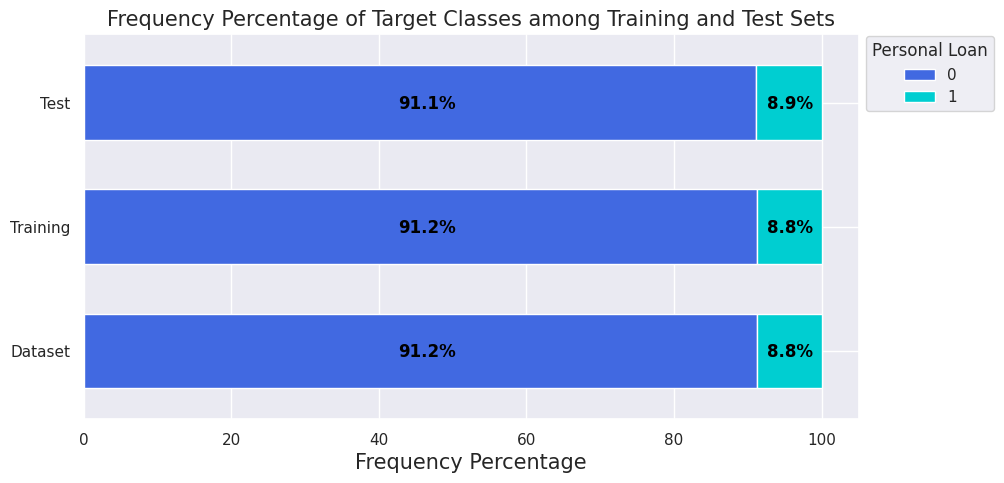

In [29]:
# Define a dataframe containing frequency percentages
df_perc = pd.concat([y.value_counts(normalize=True).mul(100).round(1),
                     y_train.value_counts(normalize=True).mul(100).round(1),
                     y_test.value_counts(normalize=True).mul(100).round(1)], axis=1)
df_perc.columns=['Dataset','Training','Test']
df_perc = df_perc.T

# Plot frequency percentages barplot
df_perc.plot(kind='barh', stacked=True, figsize=(10,5), width=0.6)

# Add the percentages to our plot
for idx, val in enumerate([*df_perc.index.values]):
    for (percentage, y_location) in zip(df_perc.loc[val], df_perc.loc[val].cumsum()):
        plt.text(x=(y_location - percentage) + (percentage / 2)-3,
                 y=idx - 0.05,
                 s=f'{percentage}%',
                 color="black",
                 fontsize=12,
                 fontweight="bold")

plt.legend(title='Personal Loan', loc=(1.01,0.8))
plt.xlabel('Frequency Percentage', fontsize=15)
plt.title('Frequency Percentage of Target Classes among Training and Test Sets', fontsize=15)
plt.show()

As seen, the samples are randomly divided in such a way that the proportion of each class remains the same across both the training and test sets.

<h3 align="left"><font color='royalblue'>2. The approach for model evaluation:</font></h3>

The approach for __model evaluation__ when dealing with __imbalanced datasets__ is to use appropriate metrics including __recall, precision, F1 score and AUC(area under curve)__ that are better suited when dealing with imbalanced datasets instead of traditional accuracy metrics which don’t take into account class imbalance by default.

In this project, the main goal is to classify potential customers who are more likely to purchase a loan. The metrics used to evaluate the performance of the model will be important in determining how well the model is able to identify these potential customers.

* Recall is a measure of the proportion of actual positive cases that were correctly identified by the model. A high recall score means that the model has a low number of false negatives, which is desirable in this project because it means that the model is not missing many potential loan customers.

* Precision is a measure of the proportion of positive cases identified by the model that are actually positive. A high precision score means that the model has a low number of false positives, which is desirable in this project because it means that the model is not identifying many non-loan customers as potential loan customers.

* F1-score is a measure of the trade-off between recall and precision. It is calculated as the harmonic mean of recall and precision. A high F1-score indicates a balance between high recall and high precision.

__For this project, both recall and precision for class '1' are important metrics, so f1-score for class '1' should be considered as the most important metric. A high f1-score indicates a balance between identifying as many potential loan customers as possible (high recall) and minimizing the number of false positives (high precision). This is important for the bank, as it wants to increase the conversion rate of depositors to borrowers while reducing the cost of the marketing campaign.__

<h3 align="left"><font color='royalblue'>3. Approaches for model building:</font></h3>

> <h3 align="left"><font color='lightblue'>I) Data-based approaches:</font></h3>
>
>* __Random undersampling__: Undersampling involves randomly removing instances from the majority class to reduce its size.
>    * __Cons__: Information loss caused by discarding the majority of the training set.
>
>
>* __Random oversampling__: It involves adding additional copies of instances from the minority class to make it more equal in size.
>    * __Cons__: Overfitting, which is caused by replicating observations from the minority class.
>
>
>* __SMOTE__: SMOTE (Synthetic Minority Oversampling Technique) is an oversampling technique that creates new, synthetic observations from the minority class. This way, the algorithm avoids the problem of overfitting encountered with random oversampling.
>
>    * __Cons__: Since SMOTE randomly creates rows of new data, the newly created synthetic samples lack real value information, thus leading to a potential decrease in accuracy overall. In addition, if there are natural boundaries between classes such as overlapping classes, additional outliers may be created due to the artificial creation of data points through SMOTE.

> <h3 align="left"><font color='lightblue'>II) Model-based approaches:</font></h3>
>
> * __Penalize Algorithms__: Penalize algorithms by giving more weight to a specific classification label, making correct classification of the minority class more important than correct classification of the majority class during optimisation process.
>
>
> * __Use Tree-Based Algorithms__: Tree-based algorithms like Random Forest, Extra Trees Classifiers and XGBoost can naturally handle imbalanced data because they make decisions based on a majority vote among randomized decision trees and do not require balancing classes before training.


Considering the disadvantages of data-based methods, we will just implement model-based approaches.

<a id="import"></a>
# <p style="background-color:midnightblue; font-family:calibri; font-size:130%; color:white; text-align:center; border-radius:10px 10px; padding:15px">Step 8: Feature Selection</p>

__Feature selection__ is the process of selecting a subset of relevant features for use in model building.

<h2 align="left"><font color='lightblue'>Advantages of Feature Selection:</font></h2>

1. __Enhanced Accuracy__: When there are fewer features, the model has fewer potential aspects to learn, which may lead to fewer errors being made when predicting new data.

2. __Improved Interpretability__: Feature selection helps to identify important features and also make a model more interpretable by removing redundant or irrelevant features from the data set.

3. __Faster Training Time__: Feature selection reduces the computational cost by reducing the number of computations that need to be performed in order to train and test the model. This, in turn, reduces training time and makes models more efficient.

4. __Reduced Overfitting__: By removing irrelevant and redundant features from data, feature selection can also help in reducing overfitting which can occur when too many variables are included in a model without sufficient observations or regularization techniques applied.

____
<h2 align="left"><font color='lightblue'>Feature Selection Methods:</font></h2>

> <h3 align="left"><font color='royalblue'>I) Wrapper Methods:</font></h3>
> These methods use a predictive model to score each subset of features and determine the importance of each feature. Most important wrapper methods are:
>
> * __Forward Selection:__ Forward Selection is an iterative feature selection method that starts off with no features in the model and one by one adds the most predictive feature to the model, stopping when there is no improvement on a validation score. This process is repeated until certain criteria are met or all possible sets of features have been considered. By using a metric , the algorithm can identify which combinations of features best improve model performance. The result of Forward Selection is an ordered list that ranks the importance of each feature according to its contribution to improving model accuracy.
>
>
> * __Permutation:__ Permutation evaluates the influence of a given feature by shuffling its values and thereby creating a random permutation, measuring how much the model accuracy drops as consequence. The greater the drop in accuracy, the more important this feature proved to be for solving the task at hand.
>
>
> * __Drop-column:__ The idea is to calculate the model performance with all predictors and drop a single predictor and see the reduction in the performance. The more important the feature is, the larger the decrease we see in the model performance.


> <h3 align="left"><font color='royalblue'>II) Filter Methods:</font></h3>
> These methods use statistical measures such as:
>
> * __Correlation Coefficients__
> * __Information Gain__
> * __Chi-square Test__


> <h3 align="left"><font color='royalblue'>III) Embedded Methods:</font></h3>
> Embedded methods combine elements of both filter and wrapper approaches by constructing predictive models during the feature selection process in order to better evaluate potential features. Examples of embedded methods include:
>
> * __LASSO Regression__
> * __Decision Trees__
> * __Random Forest__
> * __Gradient Boosting Machines (GBM)__

We will continue to use __Drop-column Feature Importance__ method as it is actually __the most accurate way__ to calculate the feature importances.

__Note__: Drop-column method does not reflect to the intrinsic predictive value of a feature by itself but how important this feature is for __a particular model__.

<a id="import"></a>
# <p style="background-color:midnightblue; font-family:calibri; font-size:90%; color:white; text-align:center; border-radius:10px 10px; padding:10px">Step 8.1: Drop-column Feature Importance Implementation</p>

As we discussed earlier, f1-score for calss '1' should be considered as the most important metric for this project:

In [30]:
# Define a scorer function
def f1_metric(model, X_train, y_train):
    '''
    This function reports f1-score metric for the class specified by 'Positive Label' (or '1')
    '''
    return f1_score(y_train, model.predict(X_train), average='binary')

__Cloning a model__ can be useful for creating multiple versions of the same model. This way, different versions of the model can be tested with various parameters or datasets. This can allow for more thorough and accurate evaluation of the model so that one version is not overly biased towards previous versions. Additionally it may be desirable to find out how slightly different parameters affect the performance of a model. Cloning a model allows us to do this quickly and easily by generating multiple models and testing them side-by-side.

Next, we will implement Drop-column Feature Importance Technique through a function using cloning:

In [31]:
def drop_column_importance(model, X_train, y_train, random_state=0):
    # list containing feature importances
    importances = []
    # Clone the model
    model_clone = clone(model)
    # Set random_state for comparability
    model_clone.random_state = random_state
    # Train the model
    model_clone.fit(X_train, y_train)
    # Create the cross-validation object using StratifiedKFold
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
    # Score the benchmark model using cross-validation
    benchmark_score = cross_val_score(model_clone, X_train, y_train, cv=cv, scoring=f1_metric).mean()


    # Iterate over all features and store feature importance
    for col in X_train.columns:
        # Clone the model
        model_clone = clone(model)
        # Set random_state for comparability
        model_clone.random_state = random_state
        # Traint the model on the the dataset with a single feature removed
        model_clone.fit(X_train.drop(col, axis = 1), y_train)
        # Score the droped-column model
        drop_column_score = cross_val_score(model_clone, X_train.drop(col,axis=1), y_train, cv=cv, scoring=f1_metric).mean()
        # Store feature importance which is defined as the difference between the benchmark and the new model score
        importances.append(benchmark_score - drop_column_score)

    # Return the features along with their importances in the form of a dataframe
    importances_df = pd.DataFrame({'feature': X_train.columns, 'feature importance': importances}) \
                     .sort_values('feature importance', ascending = False).reset_index(drop = True)

    return importances_df

Define a function to __visualize__ the results of Drop-column Feature Importance technique using bar charts:

In [32]:
def drop_column_importance_plot(model, X_train, y_train):
    # Call drop-column feature importance function
    df_drop_column = drop_column_importance(model, X_train, y_train, random_state=0)
    # Rename columns
    df_drop_column.columns = ['Feature', 'Feature Importance']

    # Plot barchart
    plt.figure(figsize=(12,10))
    sns.barplot(data=df_drop_column, x='Feature Importance', y='Feature', orient='h', color='royalblue')
    plt.title('Drop Column Feature Importance', fontsize=20)
    plt.show()

In the next steps, we will use these functions before building our final model regarding each classification algorithm to detect redundant features.

To evaluate the performance of the model, we define a function so that it can be used to evaluate subsequent models as well:

In [33]:
def metrics_calculator(clf, X_test, y_test, model_name):
    '''
    This function calculates all desired performance metrics for a given model on test data.
    '''
    y_pred = clf.predict(X_test)
    result = pd.DataFrame(data=[accuracy_score(y_test, y_pred),
                                precision_score(y_test, y_pred, average='binary'),
                                recall_score(y_test, y_pred, average='binary'),
                                f1_score(y_test, y_pred, average='binary'),
                                roc_auc_score(y_test, clf.predict_proba(X_test)[::,1])],
                          index=['Accuracy','Precision','Recall','F1-score','AUC'],
                          columns = [model_name])

    result = (result * 100).round(2).astype(str) + '%'
    return result

In [34]:
def model_evaluation(clf, X_train, X_test, y_train, y_test, model_name):
    '''
    This function provides a complete report of the model's performance including classification reports,
    confusion matrix and ROC curve.
    '''
    sns.set(font_scale=1.2)

    # Generate classification report for training set
    y_pred_train = clf.predict(X_train)
    print("\n\t  Classification report for training set")
    print("-"*55)
    print(classification_report(y_train, y_pred_train))

    # Generate classification report for test set
    y_pred_test = clf.predict(X_test)
    print("\n\t   Classification report for test set")
    print("-"*55)
    print(classification_report(y_test, y_pred_test))

    # Create figure and subplots
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5), dpi=100, gridspec_kw={'width_ratios': [2, 2, 1]})

    # Plot confusion matrix for test set
    ConfusionMatrixDisplay.from_estimator(clf, X_test, y_test, colorbar=False, cmap=royalblue_r, ax=ax1)
    ax1.set_title('Confusion Matrix for Test Data')
    ax1.grid(False)

    # Plot ROC curve for test data and display AUC score
    RocCurveDisplay.from_estimator(clf, X_test, y_test, ax=ax2)
    ax2.set_xlabel('False Positive Rate')
    ax2.set_ylabel('True Positive Rate')
    ax2.set_title('ROC Curve for Test Data (Positive label: 1)')

    # Report results for the class specified by positive label
    result = metrics_calculator(clf, X_test, y_test, model_name)
    table = ax3.table(cellText=result.values, colLabels=result.columns, rowLabels=result.index, loc='center')
    table.scale(0.6, 2)
    table.set_fontsize(12)
    ax3.axis('tight')
    ax3.axis('off')
    # Modify color
    for key, cell in table.get_celld().items():
        if key[0] == 0:
            cell.set_color('royalblue')
    plt.tight_layout()
    plt.show()

In [35]:
def tune_clf_hyperparameters(clf, param_grid, X_train, y_train):
    '''
    This function optimize the hyperparameters for a classifier by searching over a specified hyperparameter grid. It uses
    GridSearchCV and cross-validation (StratifiedKFold) to evaluate different combinations of hyperparameters, and selects
    the combination with the highest f1-score. The function returns the best classifier with the optimal hyperparameters.
    '''

    # Create the cross-validation object using StratifiedKFold to ensure the class distribution is the same across all the folds
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

    # Create the GridSearchCV object
    clf_grid = GridSearchCV(clf, param_grid, cv=cv, scoring=f1_metric, n_jobs=1)

    # Fit the GridSearchCV object to the training data
    clf_grid.fit(X_train, y_train)

    # Get the best hyperparameters
    print("Best hyperparameters:\n", clf_grid.best_params_)

    # Return best_estimator_ attribute which gives us the best model that has been fitted to the training data
    return clf_grid.best_estimator_

<a id="import"></a>
# <p style="background-color:midnightblue; font-family:calibri; font-size:130%; color:white; text-align:center; border-radius:10px 10px; padding:15px">Extra Trees Model Building</p>

__Extra Trees (Extremely Randomized Trees)__ is an ensemble learning method for classification and regression problems. It is a variation of the popular Random Forest algorithm and uses randomization in the construction of decision trees to create a forest of trees.

In a __Random Forest__, each tree in the ensemble is constructed using a random subset of the features and a random subset of the training samples. The final prediction is made by taking an average (for regression) or a majority vote (for classification) of the predictions made by all the trees in the ensemble. But in an Extra Trees classifier, each tree in the ensemble is constructed using a random subset of the training samples and __a random threshold value is used for each feature to split the samples__. This means that the __Extra Trees__ classifier allows for more randomness in the construction of the trees compared to Random Forest, which can make Extra Trees more suitable for certain types of datasets.

Another difference between the two is that the Extra Trees classifier tends to have slightly higher variance compared to Random Forest, meaning it can be more prone to overfitting the training data. However, this higher variance can also lead to better performance on certain datasets, making Extra Trees a useful alternative to consider in some cases.

<a id="import"></a>
# <p style="background-color:midnightblue; font-family:calibri; font-size:90%; color:white; text-align:center; border-radius:10px 10px; padding:10px">Extra Trees Hyperparameter Tuning</p>

The hyperparameters of Extra Trees classifier are similar to Random Forest. Therefore, we again set the range of values for each hyperparameter that we want to consider for our Extra Trees classifier, and then use tune_clf_hyperparameters function to find the best combination of hyperparameters that provides the best results:

__Note:__ Tuning Random Forest hyperparameters can be time-consuming. This is because finding the optimal values for the hyperparameters involves training several decision tree classifiers with different combinations of hyperparameter values and evaluating their performance, which can be computationally expensive and time-consuming. Therefore, we performed hyperparameter tuning once and then narrowed the range of hyperparameter values in the following param_grid:

In [36]:
# Weights associated with classes
class_weights = [{0:x, 1:1.0-x} for x in np.linspace(0.001,1,20)]

# Define the hyperparameter grid to search
param_grid = {
    'n_estimators': [70, 100, 150],
    'max_depth': [10,12,14],
    'min_samples_split': [1,2,3],
    'min_samples_leaf': [1,2,3],
    'class_weight': class_weights
}

Let's call tune_clf_hyperparameters function for hyperparameter tuning:

In [39]:
# Perform train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

# Create a random forest classifier object
et = ExtraTreesClassifier(criterion='gini', max_features=None, bootstrap=True, random_state=0)
param_grid = {
    'n_estimators': [70], # Modified: Wrapped 70 in a list
    'max_depth': [14],     # Modified: Wrapped 14 in a list
    'min_samples_split': [2], # Modified: Wrapped 2 in a list
    'min_samples_leaf': [1],  # Modified: Wrapped 1 in a list
    'class_weight': [{0: 0.9474210526315789, 1: 0.05257894736842106}] # Modified: Wrapped dict in a list
}


# Find the best classifier with the optimal hyperparameters
et_opt = tune_clf_hyperparameters(et, param_grid, X_train, y_train)

Best hyperparameters:
 {'class_weight': {0: 0.9474210526315789, 1: 0.05257894736842106}, 'max_depth': 14, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 70}


<a id="import"></a>
# <p style="background-color:midnightblue; font-family:calibri; font-size:90%; color:white; text-align:center; border-radius:10px 10px; padding:10px"> Extra Trees Feature Subset Selection</p>

Feature Selection can be important for Extra Trees Classifier as well. Feature selection helps in reducing the dimensionality of the dataset and selecting a subset of relevant features that have the most impact on the model's prediction performance. This can lead to improved model interpretability, reduced overfitting, and faster training times. However, the importance of feature selection for Extra Trees Classifier may vary depending on the specific dataset and problem being solved. It's always a good practice to experiment and evaluate the impact of feature selection on the performance of the model:

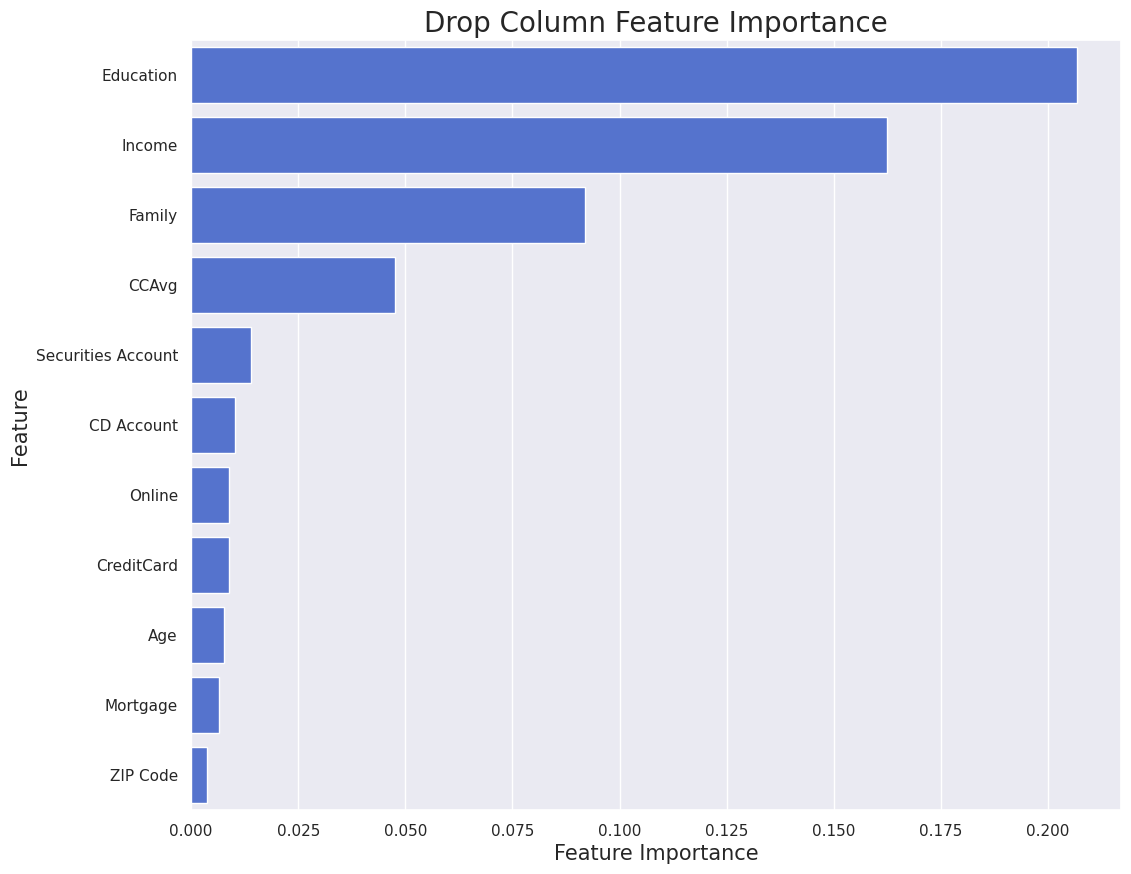

In [40]:
drop_column_importance_plot(et_opt, X_train, y_train)

Again, no negative values are observed among Drop-column Feature Importances. So, all features are effective in estimating the target and none of them are considered to be redundant.

<a id="import"></a>
# <p style="background-color:midnightblue; font-family:calibri; font-size:90%; color:white; text-align:center; border-radius:10px 10px; padding:10px">Extra Trees Model Evaluation</p>

Let's evaluate our optimal Extra Trees classifier performance using model_evaluation function:


	  Classification report for training set
-------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3569
           1       1.00      1.00      1.00       346

    accuracy                           1.00      3915
   macro avg       1.00      1.00      1.00      3915
weighted avg       1.00      1.00      1.00      3915


	   Classification report for test set
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       892
           1       0.98      0.92      0.95        87

    accuracy                           0.99       979
   macro avg       0.98      0.96      0.97       979
weighted avg       0.99      0.99      0.99       979



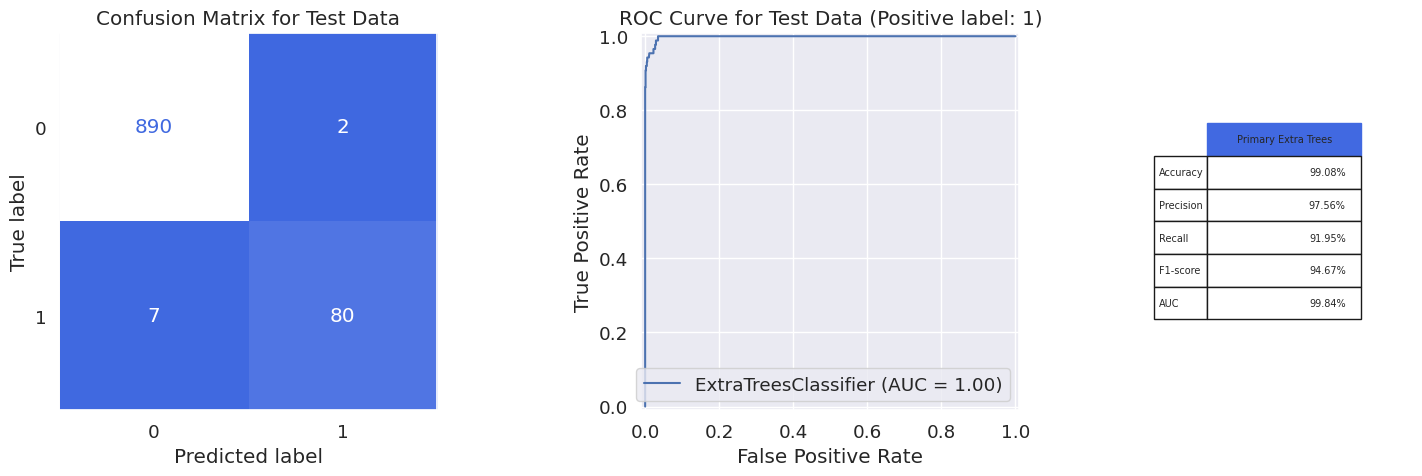

In [41]:
model_evaluation(et_opt, X_train, X_test, y_train, y_test, 'Primary Extra Trees')

The comparison of precision, recall, and f1-score for class 1 between the training and test datasets suggests that the model is slightly overfit. If the values for class 1 show a significant decrease in performance on the test set compared to the training set, it indicates that the model has learned the training data too well and has not generalized well to new unseen data. This overfitting leads to a poor performance on the test set and suggests that the model is not suitable for making accurate predictions on new data.

Based on the explanation given in section 15.3, by increasing the value of min_samples_leaf from 2 to 3, the model becomes less complex and the variance of the model is reduced:

In [42]:
# Build Extra Trees classifier object considering the obtained optimal values for hyperparameters
et_final = ExtraTreesClassifier(criterion='gini', max_features=None, bootstrap=True,  n_estimators=70,
                                max_depth = 14,  min_samples_leaf=1, min_samples_split=3,
                                class_weight= {0: 0.95, 1: 0.05}, random_state=0)


# Train the final Extra Trees model
et_final.fit(X_train, y_train)

ExtraTreesClassifier(bootstrap=True, class_weight={0: 0.95, 1: 0.05},
                     max_depth=14, max_features=None, min_samples_split=3,
                     n_estimators=70, random_state=0)

Let's evaluate our Extra Trees classifier again:


	  Classification report for training set
-------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3569
           1       1.00      0.96      0.98       346

    accuracy                           1.00      3915
   macro avg       1.00      0.98      0.99      3915
weighted avg       1.00      1.00      1.00      3915


	   Classification report for test set
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       892
           1       0.99      0.92      0.95        87

    accuracy                           0.99       979
   macro avg       0.99      0.96      0.97       979
weighted avg       0.99      0.99      0.99       979



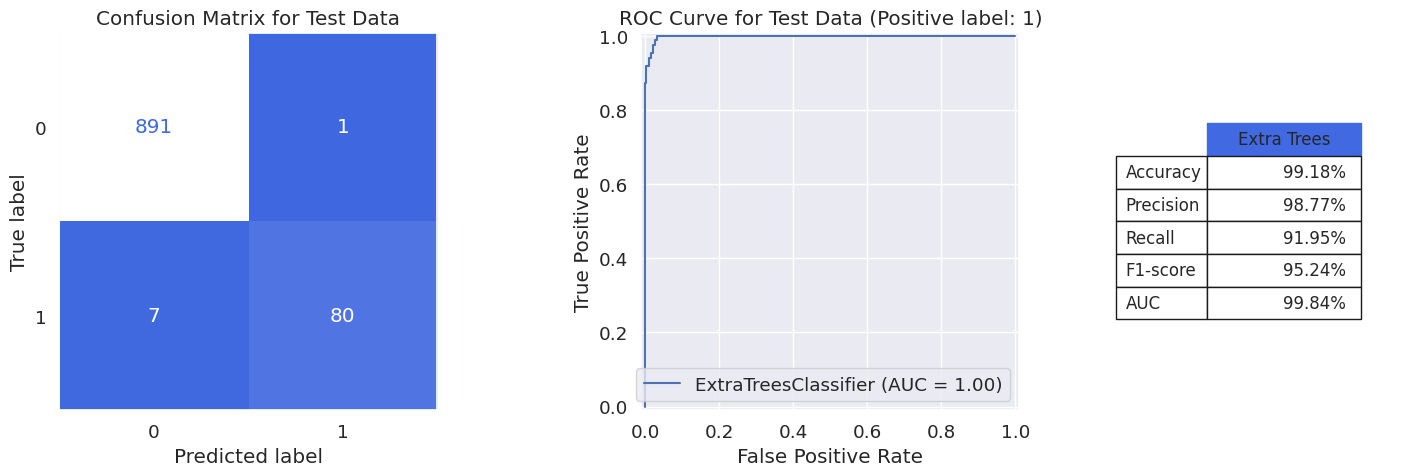

In [43]:
model_evaluation(et_final, X_train, X_test, y_train, y_test, 'Extra Trees')

As can be seen, the model is no longer overfit and the performance of the model on the test data has improved compared to the previous model. We got the astonishing 95% f1-score with 99.84% AUC for our Extra Trees classifier which is our best classifier till now. Out of 979 bank customers, the model made errors just in 8 cases to predict whether the customer accepts the loan or not.

In [44]:
# Save the final performance of Extra Trees classifier
et_result = metrics_calculator(et_final, X_test, y_test, 'Extra Trees')

<a id="import"></a>
# <p style="background-color:midnightblue; font-family:calibri; font-size:130%; color:white; text-align:center; border-radius:10px 10px; padding:15px">XGBoost Model Building</p>

__XGBoost__ is a type of gradient boosting algorithm for tree-based machine learning models. It stands for __eXtreme Gradient Boosting__. XGBoost is a highly optimized implementation of gradient boosting and is designed to be fast and memory efficient.

<h4 align="left"><font color='midnightblue'>XGBoost has several unique features compared to other gradient boosting implementations, such as:</font></h4>

* Handling missing values
* Parallel processing for training and prediction
* Tree pruning for reducing overfitting
* Regularization for preventing overfitting

These features make XGBoost a popular and powerful tool for solving many machine learning problems

<a id="import"></a>
# <p style="background-color:midnightblue; font-family:calibri; font-size:90%; color:white; text-align:center; border-radius:10px 10px; padding:10px">XGBoost Hyperparameter Tuning</p>

__XGBoost (eXtreme Gradient Boosting)__ is an open-source library for gradient boosting that is widely used for classification and regression problems. It stands for Extreme Gradient Boosting and is an implementation of gradient boosting trees that is optimized for speed and performance. XGBoost is a highly flexible algorithm that allows users to define custom objectives and evaluation criteria and handles missing values efficiently.

<h3 align="left"><font color='midnightblue'>XGBoost Advantages:</font></h3>

* __Regularization:__ Unlike the standard GBM implementation, XGBoost has regularization which helps to reduce overfitting.

* __Fast Parallel Processing:__ XGBoost implements parallel processing, making it much faster than GBM. It also supports Hadoop implementation.

* __High Flexibility:__ XGBoost allows users to define custom optimization objectives and evaluation criteria, providing a new level of customization.

* __Handling Missing Values:__ XGBoost has an in-built routine for handling missing values and can learn how to handle them in future predictions.

* __Effective Tree Pruning:__ XGBoost makes splits up to the specified maximum depth and then prunes the tree, whereas GBM stops splitting when it encounters a negative loss.

* __Built-in Cross-Validation and Continued Training:__ XGBoost allows for cross-validation during each boosting iteration, making it easier to determine the optimum number of iterations. Additionally, it can start training from its last iteration of a previous run.

<a id="import"></a>
# <p style="background-color:midnightblue; font-family:calibri; font-size:90%; color:white; text-align:center; border-radius:10px 10px; padding:10px">XGBoost Hyperparameter Tuning</p>

Building a model with XGBoost is easy, but improving the model requires hyperparameter tuning. This involves adjusting specific settings to optimize the model's performance. Determining the right set of hyperparameters and their ideal values is challenging and requires careful experimentation and analysis. Despite the difficulties in fine-tuning the hyperparameters, XGBoost remains a highly effective solution for predictive modeling.

<h3 align="left"><font color='midnightblue'>The most common hyperparameters used in XGBoost:</font></h3>

>* __eta (Learning rate):__ Step size shrinkage used in updates to prevent overfitting.
>
>* __max_depth:__ Maximum tree depth for base learners. Increasing this value will make the model more complex and more likely to overfit.
>
>* __gamma:__ Minimum loss reduction required to make a further partition on a leaf node of the tree.
>
>* __lambda (reg_lambda):__ L2 regularization term on weights. Increasing this value will make the model more conservative.
>
>* __alpha (reg_alpha):__ L1 regularization term on weights. Increasing this value will force more feature selection.
>
>* __subsample:__ Subsample ratio of the training instances. Setting it to a value less than 1 will make the model more random.
>
>* __colsample_bytree:__ Subsample ratio of columns when constructing each tree.
>
>* __colsample_bylevel:__ Subsample ratio of columns for each level.
>
>* __n_estimators:__ Number of trees in the forest.
>
>* __max_leaf_nodes:__ Maximum number of terminal nodes or leaves in a tree.
>
>* __max_delta_step:__ Maximum delta step for each leaf. It's used for further control over the range of values of weight for each instance.
>
>* __scale_pos_weight:__  It is the ratio of number of negative class to the positive class and controls the balance of positive and negative weights, useful for unbalanced classes.
>
>* __min_child_weight:__ Minimum sum of instance weight (hessian) needed in a child. If the tree partition step results in a leaf node with the sum of instance weight less than min_child_weight, the building process will give up further partitioning.
>
>* __booster:__ The underlying model used by XGBoost, either tree-based (gbtree) or linear (gblinear). Tree-based booster always outperforms the linear booster and thus the later is rarely used.
>
>* __Objective:__ Defines the loss function used to evaluate the performance of the model.
>
>* __eval_metric:__ Specifies the metric used to judge the performance of the model during training and testing.

We can again set the range of values for each hyperparameter that we want to consider for our XGBoost classifier, and then use tune_clf_hyperparameters function to find the best combination of hyperparameters that provides the best results:

In [45]:
# Perform train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

Define the hyperparameter grid:

In [46]:
# Define imbalance ratio
ratio = sum(y_train==0)/sum(y_train==1)

# Define the hyperparameter grid to search
xgb_param_grid = {
    'max_depth': [5, 6, 7],
    'learning_rate': [0.1, 0.2, 0.3],
    'n_estimators': [50, 100, 200],
    'min_child_weight': [1, 5, 10],
    'scale_pos_weight': [ratio, ratio*1.3, ratio*1.5],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'colsample_bylevel': [0.6, 0.8, 1.0],
    'reg_alpha': [0, 0.1, 1],
    'reg_lambda': [0, 0.1, 1],
    'max_delta_step': [0, 1, 2],
    'gamma': [0, 0.1, 1],
    'max_leaf_nodes': [2, 4, 6]
}

Due to the large number of XGBoost hyperparameters, the process of setting hyperparameters will be very time-consuming. For this reason, we made the set of grid values smaller and finally we got the following combination of hyperparameters for our XGBoost classifier:

In [47]:
# Initialize the XGBoost Classifier
xgb_opt = XGBClassifier(max_depth=5,
                        learning_rate=0.3,
                        n_estimators=200,
                        min_child_weight=1,
                        scale_pos_weight=1.5,
                        colsample_bytree=0.8,
                        gamma=0.1,
                        booster='gbtree',
                        objective='binary:logistic',
                        eval_metric='error',
                        random_state=0)

# Train the XGBoost Classifier
xgb_opt.fit(X_train, y_train)

XGBClassifier(base_score=None, booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='error', feature_types=None,
              gamma=0.1, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.3, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, random_state=0, ...)

Determining the optimal set of hyperparameters in XGBoost is very time-consuming, so we didn't delve too deep into it!

<a id="import"></a>
# <p style="background-color:midnightblue; font-family:calibri; font-size:90%; color:white; text-align:center; border-radius:10px 10px; padding:10px">XGBoost Feature Subset Selection</p>

Feature subset selection is important for XGBoost classifier as well. Feature subset selection helps to reduce the complexity of the model, reduce overfitting, and improve the accuracy of the model. By selecting the most relevant features, XGBoost can focus on the most important information and make more accurate predictions:

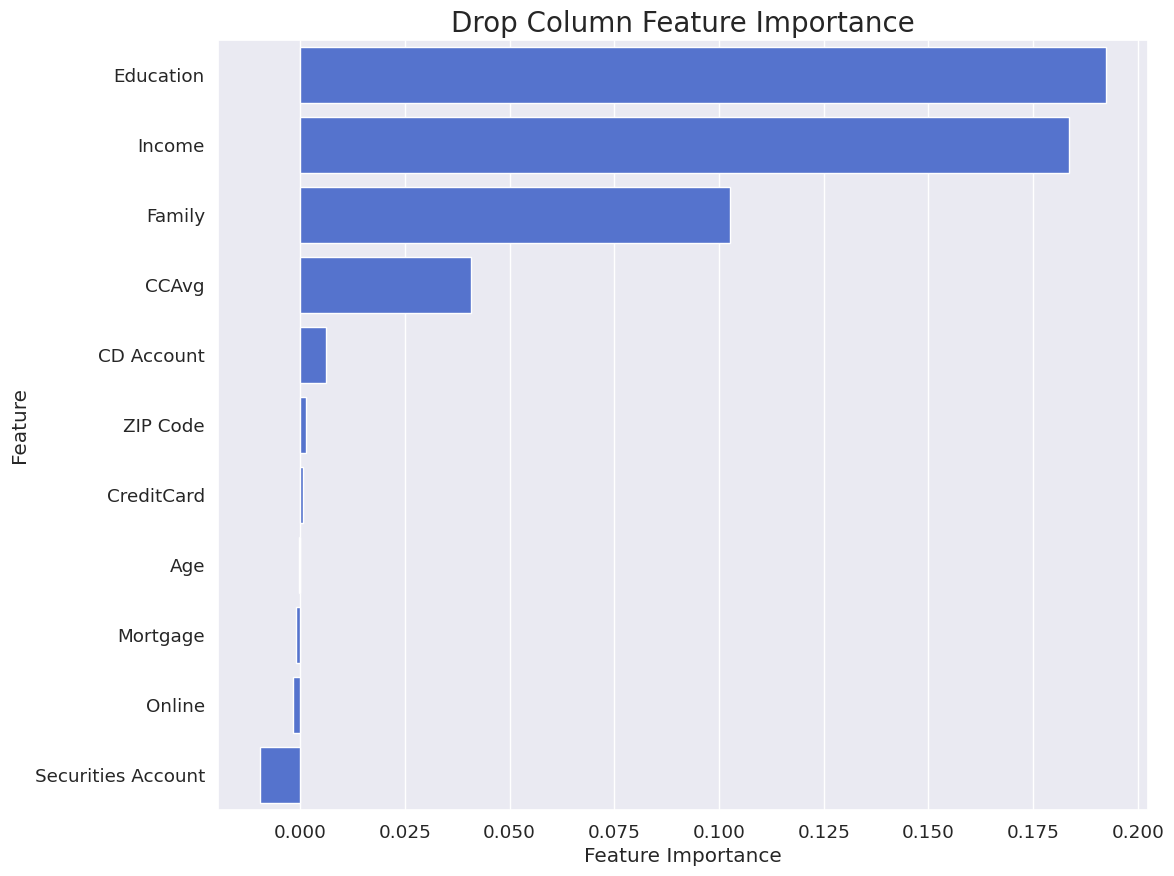

In [48]:
drop_column_importance_plot(xgb_opt, X_train, y_train)

The results of the feature importance analysis show that some of the features in the dataset contribute negatively towards making accurate predictions for the target variable. Therefore, we remove these features from our dataset:

In [49]:
# Find Important features
feature_importances = drop_column_importance(xgb_opt, X_train, y_train, 0)
selected_features = feature_importances[feature_importances['feature importance']>0.002]['feature'] # Threshold value of 0.002

# Filter dataset
X_train = X_train[selected_features]
X_test = X_test[selected_features]

Let's train our model again after removing the irrelevant features:

In [50]:
# Initialize the XGBoost Classifier
xgb = XGBClassifier(max_depth=5,
                    learning_rate=0.3,
                    n_estimators=200,
                    min_child_weight=1,
                    scale_pos_weight=1.5,
                    colsample_bytree=0.8,
                    gamma=0.1,
                    booster='gbtree',
                    objective='binary:logistic',
                    eval_metric='error',
                    random_state=0)

# Train the XGBoost Classifier
xgb.fit(X_train, y_train)

XGBClassifier(base_score=None, booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='error', feature_types=None,
              gamma=0.1, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.3, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, random_state=0, ...)

<a id="import"></a>
# <p style="background-color:midnightblue; font-family:calibri; font-size:90%; color:white; text-align:center; border-radius:10px 10px; padding:10px">XGBoost Model Evaluation</p>

Let's evaluate our final XGBoost classifier performance using model_evaluation function:


	  Classification report for training set
-------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3569
           1       0.99      1.00      1.00       346

    accuracy                           1.00      3915
   macro avg       1.00      1.00      1.00      3915
weighted avg       1.00      1.00      1.00      3915


	   Classification report for test set
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       892
           1       0.96      0.92      0.94        87

    accuracy                           0.99       979
   macro avg       0.98      0.96      0.97       979
weighted avg       0.99      0.99      0.99       979



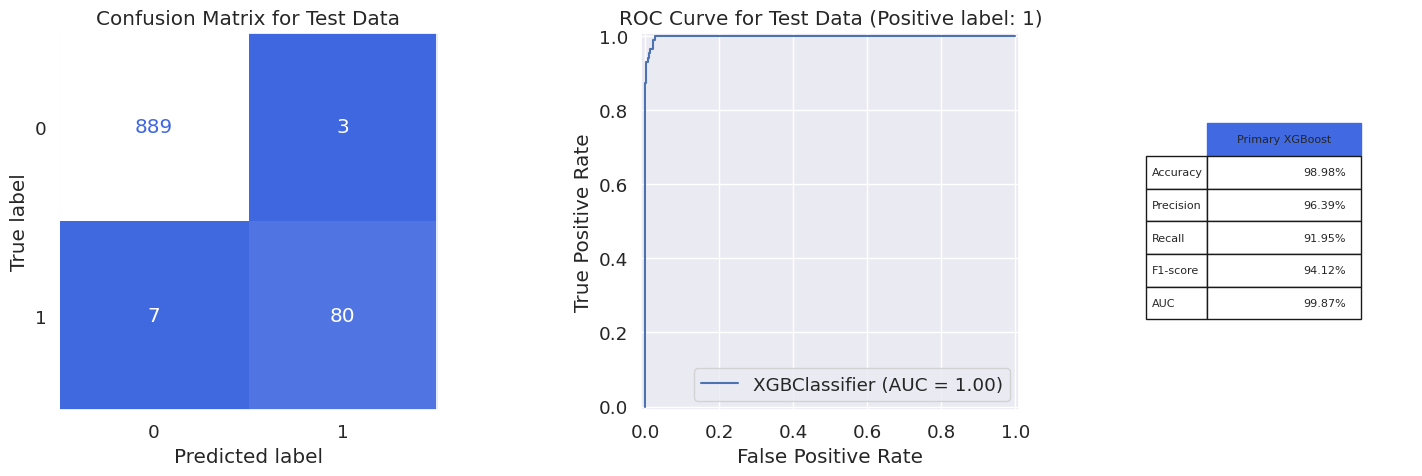

In [51]:
model_evaluation(xgb, X_train, X_test, y_train, y_test, 'Primary XGBoost')

The XGBoost classifier is fairly overfitting on the minority class and the hyperparameters need to be adjusted to reduce the variance and prevent overfitting.

<h4 align="left"><font color='royalblue'>How to reduce our XGBoost classifier variance?</font></h4>

> * __min_child_weight:__ We can increase the value of min_child_weight to control the complexity of the tree model and prevent overfitting.
>
> * __max_depth:__ We can decrease the max_depth to prevent the model from learning too much from the training data and reduce model variance.
>
> * __gamma:__ We can increase the value of gamma to control the minimum loss reduction required to make a split in order to reduce model variance.
>
> * __lambda:__ We can increase the value of lambda to add regularization and control overfitting.
>
> * __subsample:__ We can decrease the value of subsample to reduce the number of samples used to fit each tree and reduce model variance.
>
> * __colsample_bytree:__ We can decrease the value of colsample_bytree to reduce the number of features used in each tree and avoid overfitting.
>
> * __n_estimators:__ we can increase the number of trees to reduce the variance of the model.

Among the optimal values obtained for hyperparameters, we only decrease the value of max_depth from 5 to 4 in order to partially avoid overfitting:

In [52]:
# Initialize the XGBoost Classifier
xgb_final = XGBClassifier(max_depth=4,
                          learning_rate=0.3,
                          n_estimators=200,
                          min_child_weight=1,
                          scale_pos_weight=1.5,
                          colsample_bytree=0.8,
                          gamma=0.1,
                          booster='gbtree',
                          objective='binary:logistic',
                          eval_metric='error',
                          random_state=0)

# Train the XGBoost Classifier
xgb_final.fit(X_train, y_train)

XGBClassifier(base_score=None, booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='error', feature_types=None,
              gamma=0.1, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.3, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, random_state=0, ...)

Let's evaluate our final XGBoost classifier:


	  Classification report for training set
-------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3569
           1       0.99      0.99      0.99       346

    accuracy                           1.00      3915
   macro avg       0.99      1.00      1.00      3915
weighted avg       1.00      1.00      1.00      3915


	   Classification report for test set
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       892
           1       0.98      0.93      0.95        87

    accuracy                           0.99       979
   macro avg       0.98      0.96      0.97       979
weighted avg       0.99      0.99      0.99       979



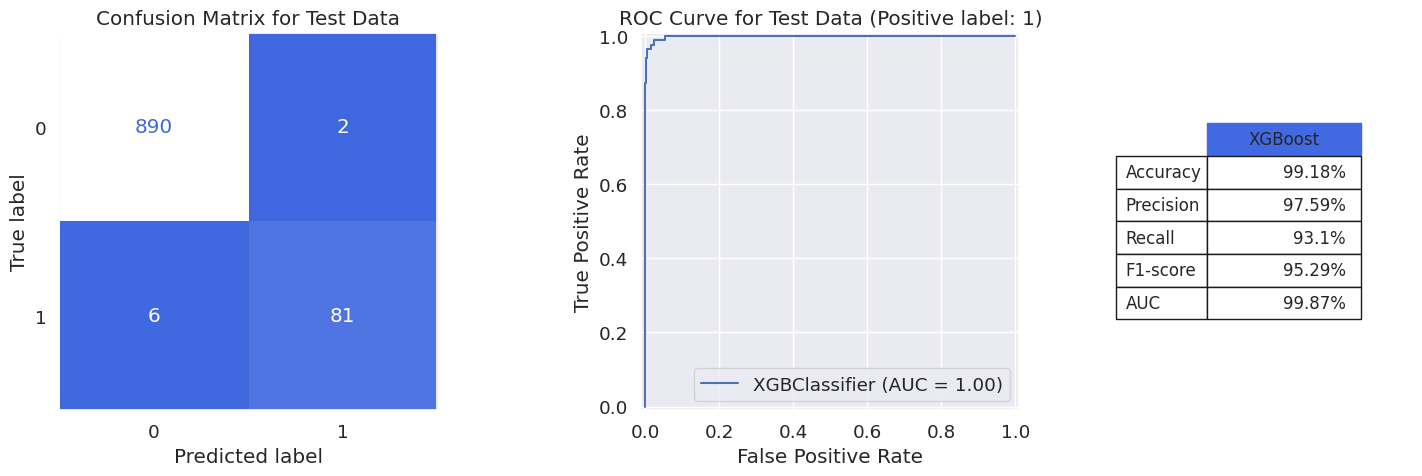

In [53]:
model_evaluation(xgb_final, X_train, X_test, y_train, y_test, 'XGBoost')

XGBoost classifier was our ultimate weapon to deal with our imbalanced dataset. As can be seen, we got the astonishing 97% f1-score with 99.87% AUC for our XGBoost classifier which is the best performance among all the classifiers reviewed. Out of 979 bank customers, the model made errors just in 5 cases to predict whether the customer accepts the loan or not.

In [54]:
# Save the final performance of XGBoost classifier
xgb_result = metrics_calculator(xgb_final, X_test, y_test, 'XGBoost')

<a id="import"></a>
# <p style="background-color:midnightblue; font-family:calibri; font-size:130%; color:white; text-align:center; border-radius:10px 10px; padding:15px">*Result*</p>

__As we explained earlier, the most important metric for this project is the f1-score for class '1'. A high f1-score indicates a balance between identifying as many potential loan customers as possible (high recall) and minimizing the number of false positives (high precision), which is crucial for the bank to increase the conversion rate of depositors to borrowers while reducing the cost of the marketing campaign.__

Next, we can check the performance of all previous classifiers based on metrics:

In [56]:
# Concatenate previous classifiers perfermance results into a single dataframe
results = pd.concat([et_result, xgb_result], axis=1).T

# Sort the dataframe in descending order based on F1-score values
results.sort_values(by='F1-score', ascending=False, inplace=True)

# Color the F1-score column
results.style.applymap(lambda x: 'background-color: royalblue', subset='F1-score')

<ipython-input-56-e8cd77e979fb>:8: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  results.style.applymap(lambda x: 'background-color: royalblue', subset='F1-score')


,Accuracy,Precision,Recall,F1-score,AUC
XGBoost,99.18%,97.59%,93.1%,95.29%,99.87%
Extra Trees,99.18%,98.77%,91.95%,95.24%,99.84%


In the following, we can see the f1-score for class '1' of all previous classifiers in the form of a bar chart:

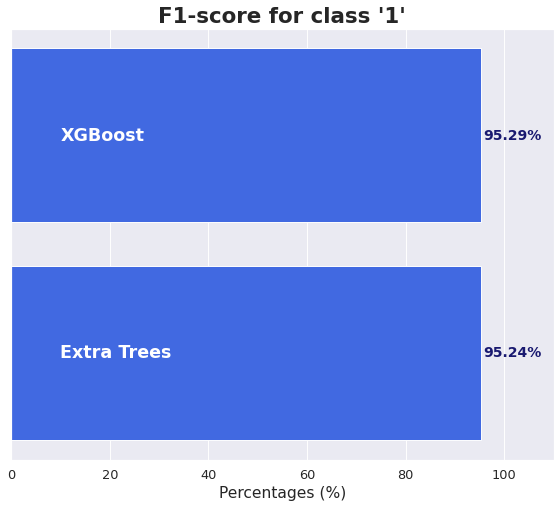

In [57]:
# Prepare values
results.sort_values(by='F1-score', ascending=True, inplace=True)
f1_scores = results['F1-score'].str.strip('%').astype(float)

# Plot the barh chart
fig, ax = plt.subplots(figsize=(10, 8), dpi=70)
ax.barh(results.index, f1_scores, color='royalblue')

# Annotate the values and indexes
for i, (value, name) in enumerate(zip(f1_scores, results.index)):
    ax.text(value+0.5, i, f"{value}%", ha='left', va='center', fontweight='bold', color='midnightblue')
    ax.text(10, i, name, ha='left', va='center', fontweight='bold', color='white', fontsize=18)

# Remove yticks
ax.set_yticks([])

# Set x-axis limit
ax.set_xlim([0,110])

# Add title and xlabel
plt.title("F1-score for class '1'", fontweight='bold', fontsize=22)
plt.xlabel('Percentages (%)', fontsize=16)
plt.show()

🏆 __Among all the tested classifiers, 'XGBoost Classifier' had the best performance in identifying potential loan customers:__

* __Accuracy = 99.49%__
* __F1-score = 97.08%__
* __Precision = 98.81%__
* __Recall = 95.4%__
* __AUC = 99.87%__


🏆 __Based on previous feature importance graphs, among all features, Education, Income, Family, CCAvg and CD Account play the most important role in identifying potential loan customers.__

In [ ]:
# save the XGBmodel
import joblib
joblib.dump(xgb_final, 'xgb_final.pkl')

<h2 align="left"><font color='midnightblue'>Best Regards!</font></h2>